<a href="https://colab.research.google.com/github/arielsaffer/PoPS-Global/blob/master/MonthlyCropHost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup workspace

In [ ]:
# set your root directory to the shared drive folder
root_dir = '/content/gdrive/My Drive/Research/Model runs/Pandemic_Model' 

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# go to root directory
%cd $root_dir 

/content/gdrive/My Drive/Research/Model runs/Pandemic_Model


In [ ]:
# Install non-default packages

!pip install geopandas faodata rasterio rasterstats rioxarray mapclassify

     |████████████████████████████████| 994 kB 14.2 MB/s 
     |████████████████████████████████| 193 kB 45.0 MB/s 
     |████████████████████████████████| 19.3 MB 68 kB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.6 MB 61.3 MB/s 
     |████████████████████████████████| 129 kB 74.5 MB/s 
  Created wheel for faodata: filename=faodata-1.1-py3-none-any.whl size=196397 sha256=2a73cce0b423b9421ddf03008f8e1c2b9144c6306e467746fa55daeb16387c46
  Stored in directory: /root/.cache/pip/wheels/a3/37/00/3ee4bbed59eaaafc62c618216baea1a874a207ce252b8ceeb9
  Created wheel for rioxarray: filename=rioxarray-0.6.1-py3-none-any.whl size=53246 sha256=bb5ff30fbc10babc9cded93ea6d68ee6cc6bfb8dc21d92de34c17c5abc1f212e
  Stored in directory: /root/.cache/pip/wheels/a8/30/1c/78

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap, BoundaryNorm

In [ ]:
import faodata
import geopandas as gpd
from rasterio.enums import Resampling
from rasterstats import zonal_stats
import rasterio
import rioxarray as rxr
from rasterio.plot import show_hist
import xarray as xr

In [ ]:
from Data.CropCalendar.crop_cover_calc import calc_crop

In [ ]:
# Read in crop calendar data

crop_calendar = pd.read_csv("inputs/crop_calendar_clean.csv")
country_crosswalk = pd.read_csv("inputs/crop_countries_crosswalk.csv")

In [ ]:
# Read in the Pandemic country shapefile

countries_geo_path = "/content/gdrive/Shared drives/APHIS  Projects/Pandemic/Data/Country_list_shapefile/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp"

In [ ]:
countries_gdf = gpd.read_file(countries_geo_path)
countries_gdf.iloc[136,4] = 'Macao'
countries_gdf.iloc[169,4] = 'Réunion'
countries_gdf.iloc[17,4] = 'Myanmar'
countries_gdf.iloc[245, 4] = 'Saint Barthelemy'

### Checks on crop calendar data quality/completeness

In [ ]:
# Some countries do not appear in the crop calendar dataset at all
missing_countries = set(countries_gdf['ISO3'].values) - set(crop_calendar['ISO3'].values)

print(f"{len(missing_countries)} missing countries.")

countries_gdf.loc[countries_gdf['ISO3'].isin(missing_countries)]

118 missing countries.


,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
0,AC,AG,ATG,28,Antigua and Barbuda,44.0,83039.0,19,29,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ..."
6,AQ,AS,ASM,16,American Samoa,20.0,64051.0,9,61,-170.730,-14.318,"MULTIPOLYGON (((-170.54251 -14.29750, -170.546..."
9,BA,BH,BHR,48,Bahrain,71.0,724788.0,142,145,50.562,26.019,"MULTIPOLYGON (((50.81249 25.64222, 50.79250 25..."
10,BB,BB,BRB,52,Barbados,43.0,291933.0,19,29,-59.559,13.153,"POLYGON ((-59.53306 13.05055, -59.54333 13.067..."
11,BD,BM,BMU,60,Bermuda,5.0,64174.0,19,21,-64.709,32.336,"MULTIPOLYGON (((-64.85584 32.27861, -64.86111 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
243,SX,GS,SGS,239,South Georgia South Sandwich Islands,0.0,0.0,0,0,-36.891,-54.209,"MULTIPOLYGON (((-27.32584 -59.42722, -27.29806..."
244,TW,TW,TWN,158,Taiwan,0.0,0.0,0,0,120.946,23.754,"MULTIPOLYGON (((121.57639 22.00139, 121.57027 ..."
245,TB,BL,BLM,652,Saint Barthelemy,NaN,NaN,19,29,-62.833,17.900,"POLYGON ((-62.81139 17.88833, -62.87000 17.913..."
246,UC,CW,CUW,531,CuraÃ§ao,NaN,NaN,19,29,-68.990,12.169,"POLYGON ((-68.96556 12.19889, -68.87889 12.182..."


In [ ]:
crop_calendar.head()

,Unnamed: 0,Location,Nation.code,Crop,Crop.name.in.original.data,Plant.start,Plant.end,Plant.median,Harvest.start,Harvest.end,Harvest.median,full.crop.name,location.code,ISO3,Name
0,0,Albania,55,Wheat,Wheat,10,12,11,5.0,7.0,6,Wheat.Winter,55,ALB,Albania
1,1,Albania,55,Maize,Maize,4,6,5,8.0,11.0,9,Maize,55,ALB,Albania
2,2,Albania,55,Pulses,Beans,4,6,5,7.0,9.0,8,Pulses,55,ALB,Albania
3,3,Albania,55,Other,Winter vegetables,10,12,11,2.0,4.0,3,Other.Winter vegetables,55,ALB,Albania
4,4,Albania,55,Other,Spring vegetables (field planting),4,5,5,8.0,10.0,9,Other.Spring field vegetables,55,ALB,Albania


In [ ]:
# Harvest dates for many crops are missing for observations in Russia and Ukraine

crop_calendar.loc[crop_calendar['Harvest.start'].isna()].value_counts(['Name'])

Name   
Russia     49
Ukraine    30
dtype: int64

In [ ]:
# Another data issue in Eastern Europe - crop classification as "Multiple"

crop_calendar.loc[crop_calendar['Crop']=='Multiple'].head()

,Unnamed: 0,Location,Nation.code,Crop,Crop.name.in.original.data,Plant.start,Plant.end,Plant.median,Harvest.start,Harvest.end,Harvest.median,full.crop.name,location.code,ISO3,Name
7,7,Albania,55,Multiple,Forage,11,5,1,5.0,11.0,8,Multiple.Forage,55,ALB,Albania
22,22,Armenia,61,Multiple,Spring Coarse Grains,4,7,5,8.0,10.0,9,Multiple.Spring,61,ARM,Armenia
23,23,Azerbaijan,54,Multiple,Winter Grains,11,1,12,6.0,8.0,7,Multiple.Winter,54,AZE,Azerbaijan
24,24,Azerbaijan,54,Multiple,Spring Grains,3,5,4,7.0,9.0,8,Multiple.Spring,54,AZE,Azerbaijan
31,31,Belarus,16,Multiple,Winter Cereals,8,11,9,7.0,8.0,7,Multiple.Winter,16,BLR,Belarus


### Some crops have more data or are more widely grown than others

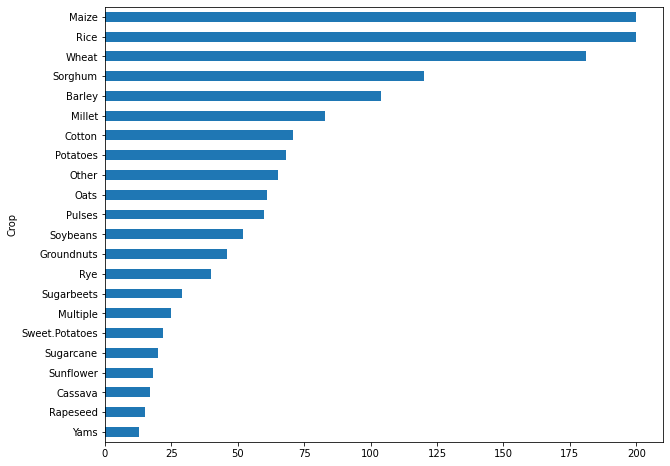

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
crop_calendar.value_counts('Crop').sort_values(ascending=True).plot.barh(ax=ax)

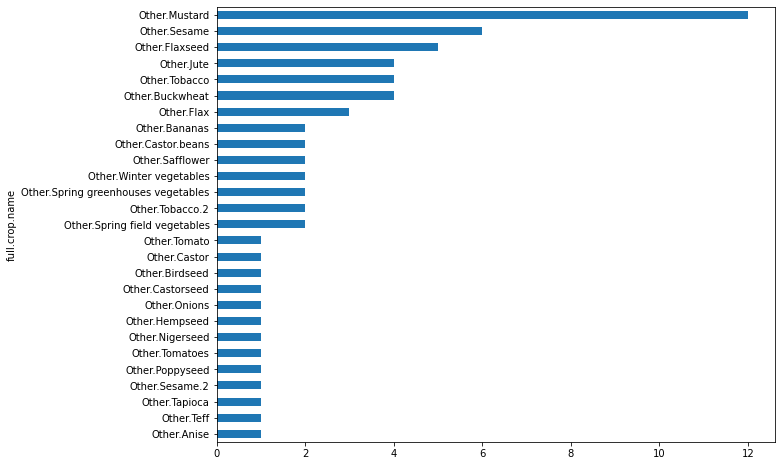

In [ ]:
# Dataset is probably only useful for crops not listed as "Other" - very few observations

f, ax = plt.subplots(figsize=(10, 8))
crop_calendar.loc[crop_calendar['Crop']=='Other'].value_counts('full.crop.name').sort_values(ascending=True).plot.barh(ax=ax)

### Run crop-month calculations

In [ ]:
# Applying the calculation to all records of a given crop, by country

def crop_country_calc(country): 
    country_crop = crop_df.loc[crop_df['ISO3']==country]
    # if no results for that country (if there's no info here, 
    # we refer to the crop host layer, but reduce the overall percentage?)
    if len(country_crop) == 0:
        results = np.empty((1,12)) * np.nan
        # results = np.repeat(0.45, 12)
        # Temporary value - replace with value from the nearest country/weight nearest neighbors/imputation based on location?
    elif len(country_crop) == 1: 
        results = calc_crop(country_crop.iloc[0])
    else: 
        # How to handle multiple cycles
        temp_results = calc_crop(country_crop.iloc[0])
        for row in range(1,len(country_crop)):
            crop = country_crop.iloc[row]
            result = calc_crop(crop)
            temp_results = np.vstack((temp_results,result))
        # If planting occurs in same location, Nation.code == location.code, pick max value between all rows
        # If there are multiple locations, Nation.code != location.code, take mean value
        if all(country_crop['Nation.code'] == country_crop['location.code']):
            results = temp_results.max(axis=0)
        else: results = temp_results.mean(axis=0)
    return(results)

# Defining the list of crop name options

crop_list = []
for i in crop_calendar['Crop'].unique(): 
  crop_list.append(i)
for i in crop_calendar.loc[crop_calendar['Crop']=='Other']['full.crop.name'].unique():
  crop_list.append(i.split('.')[1])

crop_options = '\n'.join([str(elem) for elem in crop_list])

In [ ]:
# Set a crop name

crop_name = 'Maize'

# Leave the below

crop_df = crop_calendar.loc[crop_calendar['Crop'] == crop_name]

if (len(crop_df.index)==0): 
  crop_df = crop_calendar.loc[crop_calendar['full.crop.name']==f'Other.{crop_name}']
if (len(crop_df.index)==0): 
  print(f"Crop '{crop_name}' not found, try again? \n Options are:\n {crop_options}")

country_crosswalk['month_values'] = country_crosswalk.ISO3.apply(crop_country_calc)

In [ ]:
crop_df

,Unnamed: 0,Location,Nation.code,Crop,Crop.name.in.original.data,Plant.start,Plant.end,Plant.median,Harvest.start,Harvest.end,Harvest.median,full.crop.name,location.code,ISO3,Name
1,1,Albania,55,Maize,Maize,4,6,5,8.0,11.0,9,Maize,55,ALB,Albania
14,14,Angola,191,Maize,Maize,9,11,10,3.0,5.0,4,Maize,191,AGO,Angola
36,36,Benin,149,Maize,Maize (main),3,5,4,8.0,10.0,9,Maize,149,BEN,Benin
37,37,Benin,149,Maize,Maize (second),8,10,9,12.0,2.0,1,Maize.2,149,BEN,Benin
45,45,Bolivia,201,Maize,Maize,9,11,10,3.0,5.0,4,Maize,201,BOL,Bolivia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,1381,Voronezh,3,Maize,Corn,5,5,5,NaN,NaN,9,Maize,1097,RUS,Russia
1416,1416,Iran,63,Maize,Corn,3,6,4,7.0,10.0,8,Maize,63,IRN,Iran (Islamic Republic of)
1421,1421,Iraq,66,Maize,Corn,6,7,6,9.0,10.0,9,Maize,66,IRQ,Iraq
1470,1470,Syria,68,Maize,Corn,3,5,4,8.0,9.0,9,Maize,68,SYR,Syrian Arab Republic


In [ ]:
means = []
for row in range(0, len(country_crosswalk)):
    means.append(country_crosswalk['month_values'][row].mean().mean())

country_crosswalk['mean_annual'] = means

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
country_crosswalk.loc[country_crosswalk['Name']=='Russia']

,Unnamed: 0,Location,Nation.code,ISO3,Name,month_values,mean_annual
71,71,Russia,3,RUS,Russia,[],NaN


### Visualizing the monthly/annual data

Overview of a single country, hist. of annual means by country

Maps of mean values are below



,Unnamed: 0,Location,Nation.code,Crop,Crop.name.in.original.data,Plant.start,Plant.end,Plant.median,Harvest.start,Harvest.end,Harvest.median,full.crop.name,location.code,ISO3,Name
281,281,Kenya,176,Maize,Maize (long rains),3,5,4,10.0,12.0,11,Maize,176,KEN,Kenya
282,282,Kenya,176,Maize,Maize (short rains),10,12,11,3.0,5.0,4,Maize.2,176,KEN,Kenya


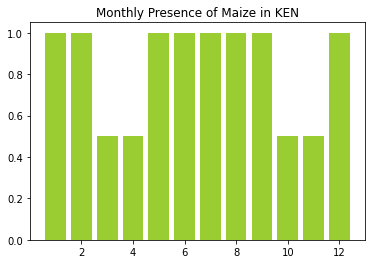

In [ ]:
country = "KEN" # USA, AUS, KEN, NPL, MWI

# By country; change ISO3 code above

x = list(range(1,13))
i = np.max(np.where([country_crosswalk['ISO3']==country]))
y = country_crosswalk['month_values'][i]

plt.bar(x,y, color='yellowgreen')
plt.title(f'Monthly Presence of {crop_name} in {country}')

crop_df.loc[crop_df['ISO3']==country]


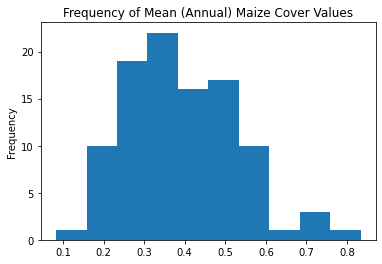

In [ ]:
# Overview of frequency of annual means

country_crosswalk['mean_annual'].plot.hist(title=f'Frequency of Mean (Annual) {crop_name} Cover Values')

### Review the crop host data

In [ ]:
# Read Human Influence Index layer (already resampled to match Koppen raster)
hii_arr = rxr.open_rasterio("/content/gdrive/Shared drives/APHIS  Projects/Pandemic/Data/land_use/human_influence_index/hii_v2_resamp.tif", masked=True).squeeze()

# hii_arr = hii.read(1)
hii_arr = hii_arr.astype('float64')
print(hii_arr.shape, np.nanmax(hii_arr), np.nanmin(hii_arr))

(2160, 4320) 64.0 0.0


In [ ]:
# Create mask to exclude areas with values below the threshold 
# from the % area calculations of climate similaritiy and 
# host availability 
threshold_val = 16

# # Mask values less than threshold (water is already 255)
# hii_arr[hii_arr < threshold_val] = 0
# hii_arr[hii_arr == 255] = 0

# # Keep areas greater than threshold
# hii_arr[hii_arr >= threshold_val] = 1
# hii_arr[hii_arr == 0] = np.nan

# hii_arr = hii_arr.where(hii_arr != 255, np.nan)
# hii_arr = hii_arr.where(hii_arr >= threshold_val, np.nan)

class_bins = [-np.inf,threshold_val-0.01,np.inf]
hii_arr = xr.apply_ufunc(np.digitize,
                        hii_arr, class_bins)

hii_arr = hii_arr.where(hii_arr == 2, np.nan)
print(hii_arr.shape, np.nanmax(hii_arr), np.nanmin(hii_arr))

(2160, 4320) 2.0 2.0


In [ ]:
hii_arr = hii_arr/2

In [ ]:
print(hii_arr.shape, np.nanmax(hii_arr), np.nanmin(hii_arr))

(2160, 4320) 1.0 1.0


In [ ]:
# Convert the EarthStat map
crop_host_path = os.path.join('inputs',
                              'maize_HarvAreaYield_Geotiff',
                              'maize_HarvestedAreaHectares.tif')

host_arr = rxr.open_rasterio(crop_host_path, masked=True).squeeze()
# host_arr = host.read(1)

# Set large negative values to 0
#print(np.nanmax(host_arr), np.nanmin(host_arr))
#host_arr[host_arr <= 0] = 0

print(np.nanmax(host_arr), np.nanmin(host_arr))

14189.425 0.0


In [ ]:
# Open the EarthStat map
crop_host_path = os.path.join('inputs',
                              'maize_HarvAreaYield_Geotiff',
                              'maize_HarvestedAreaFraction.tif')

host_frac = rxr.open_rasterio(crop_host_path, masked=True).squeeze()
# host_arr = host.read(1)

# Set large negative values to 0
#print(np.nanmax(host_arr), np.nanmin(host_arr))
#host_arr[host_arr <= 0] = 0

print(np.nanmax(host_frac), np.nanmin(host_frac))

1.7261612 0.0


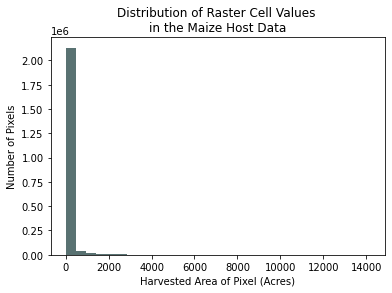

In [ ]:
f, ax = plt.subplots()
host_arr.plot.hist(color='darkslategrey', bins=30, alpha=0.8, ax=ax)
ax.set(title=f"Distribution of Raster Cell Values \nin the {crop_name} Host Data",
       xlabel="Harvested Area of Pixel (Acres)",
       ylabel="Number of Pixels")
plt.show()

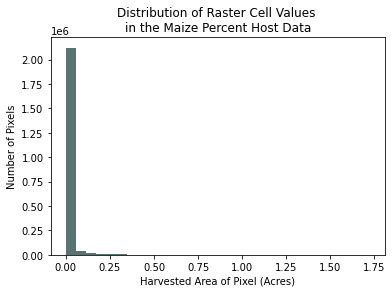

In [ ]:
f, ax = plt.subplots()
host_frac.plot.hist(color='darkslategrey', bins=30, alpha=0.8, ax=ax)
ax.set(title=f"Distribution of Raster Cell Values \nin the {crop_name} Percent Host Data",
       xlabel="Harvested Area of Pixel (Acres)",
       ylabel="Number of Pixels")
plt.show()

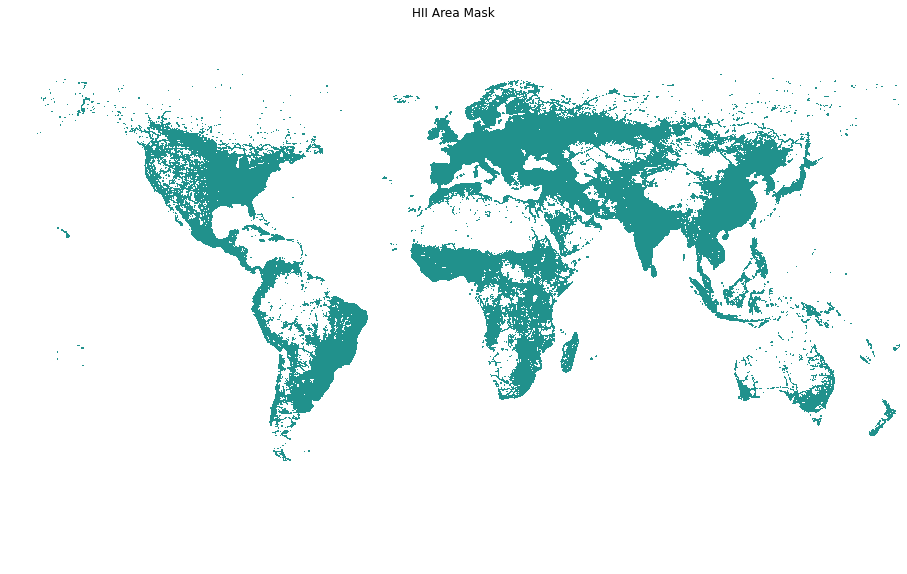

In [ ]:
f, ax = plt.subplots(figsize=(16,10))
hii_arr.plot(add_colorbar=False)
ax.set(title=f"HII Area Mask")
ax.set_axis_off()
plt.show()

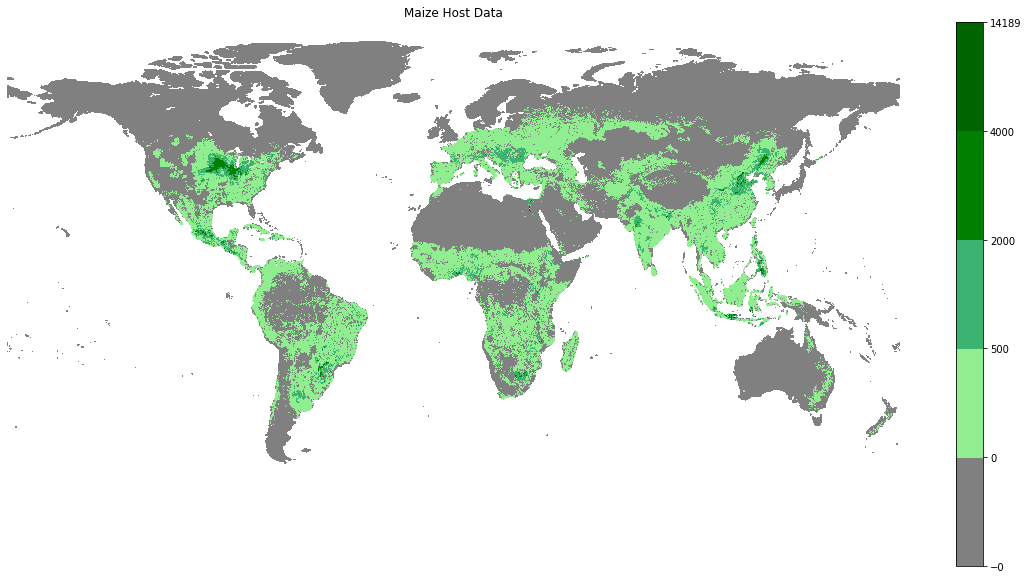

In [ ]:
colors = ['grey', 'lightgreen', 'mediumseagreen','green','darkgreen']
class_bins = [-0.5, 0.5, 500, 2000, 4000, np.nanmax(host_arr)]

cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

f, ax = plt.subplots(figsize=(20,10))
host_arr.plot(cmap=cmap, norm=norm)
ax.set(title=f"{crop_name} Host Data")
ax.set_axis_off()
plt.show()

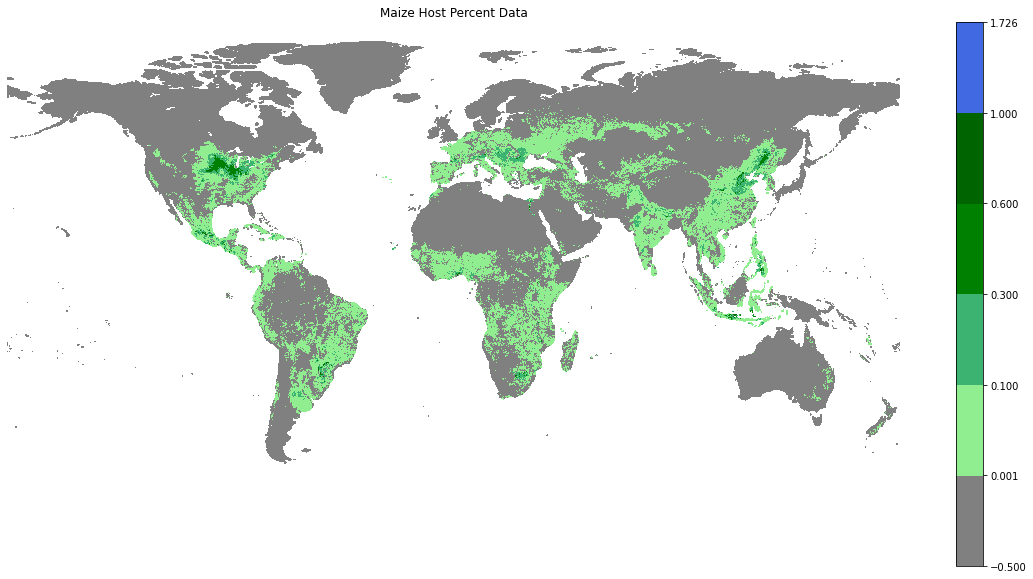

In [ ]:
colors = ['grey', 'lightgreen', 'mediumseagreen','green','darkgreen','royalblue']
class_bins = [-0.5, 0.001, 0.1, 0.3, 0.6, 1, np.nanmax(host_frac)]

cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

f, ax = plt.subplots(figsize=(20,10))
host_frac.plot(cmap=cmap, norm=norm)
ax.set(title=f"{crop_name} Host Percent Data")
ax.set_axis_off()
plt.show()

In [ ]:
print(host_arr.rio.crs == hii_arr.rio.crs, host_arr.rio.bounds == hii_arr.rio.bounds)

True False


In [ ]:
print(host_arr.rio.bounds(), hii_arr.rio.bounds())

(-180.0, -90.0, 179.9999999999795, 89.99999999998977) (-180.0, -89.99999999999999, 179.99999999999997, 90.0)


In [ ]:
host_hii_arr = np.append(host_arr, np.zeros([hii_arr.shape[0] - host_arr.shape[0], host_arr.shape[1]]), axis=0)
host_masked = host_hii_arr * hii_arr
# host_masked = host_masked.where(host_masked != 0, np.nan)

In [ ]:
hostfrac_hii_arr = np.append(host_frac, np.zeros([hii_arr.shape[0] - host_frac.shape[0], host_frac.shape[1]]), axis=0)
hostfrac_masked = hostfrac_hii_arr * hii_arr
# host_masked = host_masked.where(host_masked != 0, np.nan)

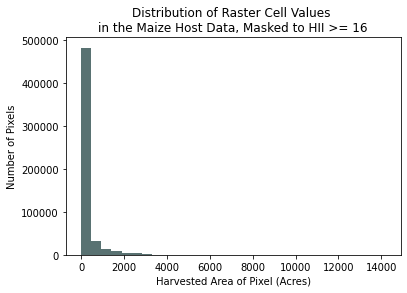

In [ ]:
f, ax = plt.subplots()
host_masked.plot.hist(color='darkslategrey', bins=30, alpha=0.8, ax=ax)
ax.set(title=f"Distribution of Raster Cell Values \nin the {crop_name} Host Data, Masked to HII >= 16",
       xlabel="Harvested Area of Pixel (Acres)",
       ylabel="Number of Pixels")
plt.show()

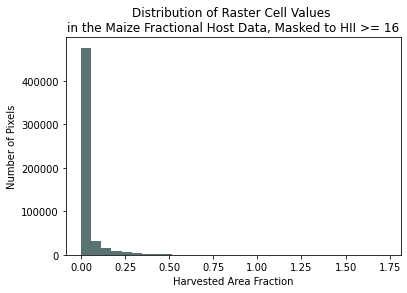

In [ ]:
f, ax = plt.subplots()
hostfrac_masked.plot.hist(color='darkslategrey', bins=30, alpha=0.8, ax=ax)
ax.set(title=f"Distribution of Raster Cell Values \nin the {crop_name} Fractional Host Data, Masked to HII >= 16",
       xlabel="Harvested Area Fraction",
       ylabel="Number of Pixels")
plt.show()

In [ ]:
# Reprojecting relevant layers - this is RAM/time consuming, so written to file

# hii_reproj = hii_arr.rio.reproject("+proj=laea +lat_0=45.5 +lon_0=-114.125 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs")

In [ ]:
# countries_reproj = countries_gdf.to_crs("+proj=laea +lat_0=45.5 +lon_0=-114.125 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs")

In [ ]:
# hostfrac_masked_reproj = hostfrac_masked.rio.reproject("+proj=laea +lat_0=45.5 +lon_0=-114.125 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs")


In [ ]:
data_path = os.path.join('inputs',
                        'reprojected')

# One-time write to file - to save time on reprojecting

# if os.path.exists(data_path):
#     print("The directory", data_path, "exists!")
# else:
#     os.makedirs(data_path)

# crop_host_path = os.path.join('inputs',
#                               'maize_HarvAreaYield_Geotiff',
#                               'maize_HarvestedAreaFraction.tif')

# hii_reproj.rio.to_raster(os.path.join(data_path,
#                                       'hii_area.tif'))
# hostfrac_masked_reproj.rio.to_raster(os.path.join(data_path,
#                                       'hostfrac_area.tif'))
# countries_reproj.to_file(os.path.join(data_path,
#                                       'countries_area.shp'))

In [ ]:
hii_reproj = rxr.open_rasterio(os.path.join(data_path,
                                      'hii_area.tif'), masked=True).squeeze()
hostfrac_masked_reproj = rxr.open_rasterio(os.path.join(data_path,
                                      'hostfrac_area.tif'), masked=True).squeeze()
countries_reproj = gpd.read_file(os.path.join(data_path,
                                      'countries_area.shp'))

In [ ]:
# Calculate zonal statistics on rasters reprojected to equal area ()

# The total area under Human Influence for each country (count)
affine = hii_reproj.rio.transform()
area_stats = zonal_stats(countries_reproj, hii_reproj.values, stats='count', affine = affine)

# The total host acreage in a country (sum)
# For this one I did not reproject because area is already defined in the current projection 
affine = host_masked.rio.transform()
host_stats = zonal_stats(countries_gdf, host_masked.values, stats='sum', affine = affine)

# The fractional host area in a country (sum)
# This is reprojected, because it is the percent of each cell, so needs to correspond to the right area?
affine = hostfrac_masked_reproj.rio.transform()
hostfrac_stats = zonal_stats(countries_reproj, hostfrac_masked_reproj.values, stats='sum', affine = affine)

/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [ ]:
host_df = countries_gdf.loc[:, ['ISO3', 'NAME','geometry']]
host_df['area_stats'] = area_stats
host_df['host_stats'] = host_stats
host_df['hostfrac_stats'] = hostfrac_stats

host_df = pd.concat([host_df, host_df['area_stats'].apply(pd.Series)], axis=1).fillna(0)
host_df = pd.concat([host_df, host_df['host_stats'].apply(pd.Series)], axis=1).fillna(0)
host_df.rename(columns={'sum':'sum_area'}, inplace=True)

host_df = pd.concat([host_df, host_df['hostfrac_stats'].apply(pd.Series)], axis=1).fillna(0)
host_df.rename(columns={'sum':'sum_frac'}, inplace=True)

host_df['Area_total'] = countries_reproj.area/10000
host_df['Area_HII'] = host_df['count'] * (hii_reproj.rio.resolution()[0]**2) / 10000

host_df['Host Percent Area - HII'] = (host_df['sum_area'] / host_df['Area_HII']).fillna(0)
host_df['Host Percent Area - All'] = (host_df['sum_area'] / host_df['Area_total']).fillna(0)
host_df['Host Percent Area - Frac'] = (host_df['sum_frac'] / host_df['count']).fillna(0)

host_df.iloc[136,1] = 'Macao'
host_df.iloc[169,1] = 'Réunion'
host_df.iloc[17,1] = 'Myanmar'
host_df.iloc[245, 1] = 'Saint Barthelemy'
host_df.head()

,ISO3,NAME,geometry,area_stats,host_stats,hostfrac_stats,count,sum_area,sum_frac,Area_total,Area_HII,Host Percent Area - HII,Host Percent Area - All,Host Percent Area - Frac
0,ATG,Antigua and Barbuda,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ...",{'count': 25},{'sum': 0.0},{'sum': 0.027290134807117283},25,0.000000,0.027290,5.452431e+04,2.959510e+04,0.000000,0.000000e+00,0.001092
1,DZA,Algeria,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",{'count': 10523},{'sum': 93.61268091201782},{'sum': 0.08058844244806096},10523,93.612681,0.080588,2.320865e+08,1.245717e+07,0.000008,4.033525e-07,0.000008
2,AZE,Azerbaijan,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...",{'count': 5403},{'sum': 18724.662415504456},{'sum': 16.813879966884997},5403,18724.662416,16.813880,8.582157e+06,6.396093e+06,0.002928,2.181813e-03,0.003112
3,ALB,Albania,"POLYGON ((19.43621 41.02107, 19.45055 41.06000...",{'count': 1962},{'sum': 48863.84143424034},{'sum': 42.17288336105412},1962,48863.841434,42.172883,2.863982e+06,2.322624e+06,0.021038,1.706150e-02,0.021495
4,ARM,Armenia,"MULTIPOLYGON (((45.57305 40.63249, 45.52888 40...",{'count': 1802},{'sum': 1641.1384580284357},{'sum': 1.9707227694332232},1802,1641.138458,1.970723,2.963436e+06,2.133215e+06,0.000769,5.537959e-04,0.001094


In [ ]:
combined_maize = pd.merge(left=host_df, right=country_crosswalk[['ISO3','month_values','mean_annual']], how="left", on="ISO3")
combined_maize.sort_values('Host Percent Area - HII', ascending = False).head()

,ISO3,NAME,geometry,area_stats,host_stats,hostfrac_stats,count,sum_area,sum_frac,Area_total,Area_HII,Host Percent Area - HII,Host Percent Area - All,Host Percent Area - Frac,month_values,mean_annual
236,SRB,Serbia,"POLYGON ((20.07142 42.56091, 20.10583 42.64278...",{'count': 6572},{'sum': 1102938.0328416824},{'sum': 933.5785305307945},6572,1.102938e+06,933.578531,8.793605e+06,7.779960e+06,0.141767,0.125425,0.142054,NaN,NaN
170,ROU,Romania,"POLYGON ((20.72696 46.17556, 20.72000 46.18749...",{'count': 17393},{'sum': 2882470.92679286},{'sum': 2452.352691623295},17393,2.882471e+06,2452.352692,2.368026e+07,2.058990e+07,0.139994,0.121725,0.140997,"[0.0, 0.0, 0.25, 0.5, 1.0, 1.0, 0.5, 0.25, 0.0...",0.291667
54,SLV,El Salvador,"MULTIPOLYGON (((-87.68640 13.16833, -87.70361 ...",{'count': 1721},{'sum': 272303.96601867676},{'sum': 234.08066324843094},1721,2.723040e+05,234.080663,2.066154e+06,2.037327e+06,0.133657,0.131793,0.136014,"[1.0, 0.25, 0.0, 0.0, 0.25, 0.5, 1.0, 0.5, 0.5...",0.583333
80,HUN,Hungary,"POLYGON ((18.81702 45.91296, 18.80750 45.90277...",{'count': 7454},{'sum': 1077907.9456076622},{'sum': 917.2986038894742},7454,1.077908e+06,917.298604,9.273498e+06,8.824075e+06,0.122155,0.116235,0.123061,"[0.0, 0.0, 0.25, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5,...",0.416667
77,HTI,Haiti,"MULTIPOLYGON (((-73.58473 18.05694, -73.59056 ...",{'count': 1944},{'sum': 250350.5443611145},{'sum': 212.081230333657},1944,2.503505e+05,212.081230,2.734118e+06,2.301315e+06,0.108786,0.091565,0.109095,"[0.0, 0.25, 0.5, 1.0, 1.0, 0.5, 0.25, 0.25, 0....",0.312500


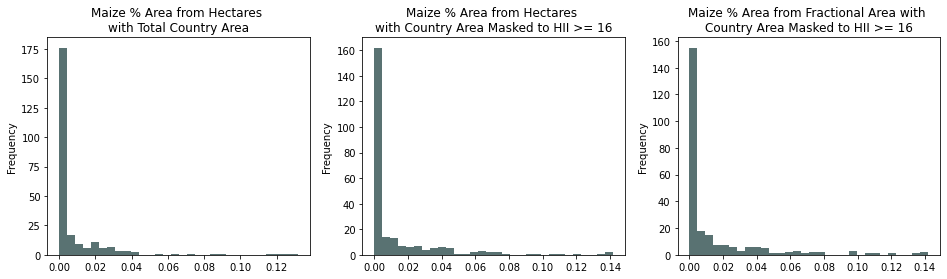

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
combined_maize['Host Percent Area - All'].plot.hist(color='darkslategrey', bins=30, alpha=0.8, ax=ax1)
combined_maize['Host Percent Area - HII'].plot.hist(color='darkslategrey', bins=30, alpha=0.8, ax=ax2)
combined_maize['Host Percent Area - Frac'].plot.hist(color='darkslategrey', bins=30, alpha=0.8, ax=ax3)
ax1.set(title=f"{crop_name} % Area from Hectares \nwith Total Country Area")
ax2.set(title=f"{crop_name} % Area from Hectares \nwith Country Area Masked to HII >= 16")
ax3.set(title=f"{crop_name} % Area from Fractional Area with \nCountry Area Masked to HII >= 16")
plt.show()

In [ ]:
# Double checking the high values

# combined_maize.loc[combined_maize['Host Percent Area - HII']>=1]
combined_maize.sort_values('Host Percent Area - HII', ascending=False).head(3)

,ISO3,NAME,geometry,area_stats,host_stats,hostfrac_stats,count,sum_area,sum_frac,Area_total,Area_HII,Host Percent Area - HII,Host Percent Area - All,Host Percent Area - Frac,month_values,mean_annual
236,SRB,Serbia,"POLYGON ((20.07142 42.56091, 20.10583 42.64278...",{'count': 6572},{'sum': 1102938.0328416824},{'sum': 933.5785305307945},6572,1.102938e+06,933.578531,8.793605e+06,7.779960e+06,0.141767,0.125425,0.142054,NaN,NaN
170,ROU,Romania,"POLYGON ((20.72696 46.17556, 20.72000 46.18749...",{'count': 17393},{'sum': 2882470.92679286},{'sum': 2452.352691623295},17393,2.882471e+06,2452.352692,2.368026e+07,2.058990e+07,0.139994,0.121725,0.140997,"[0.0, 0.0, 0.25, 0.5, 1.0, 1.0, 0.5, 0.25, 0.0...",0.291667
54,SLV,El Salvador,"MULTIPOLYGON (((-87.68640 13.16833, -87.70361 ...",{'count': 1721},{'sum': 272303.96601867676},{'sum': 234.08066324843094},1721,2.723040e+05,234.080663,2.066154e+06,2.037327e+06,0.133657,0.131793,0.136014,"[1.0, 0.25, 0.0, 0.0, 0.25, 0.5, 1.0, 0.5, 0.5...",0.583333


In [ ]:
combined_maize['Host Difference'] = abs(combined_maize['Host Percent Area - Frac'] - combined_maize['Host Percent Area - HII'])

combined_maize[['NAME','Host Difference']].sort_values('Host Difference', ascending=False).head(10)

,NAME,Host Difference
41,Cape Verde,0.073469
171,Republic of Moldova,0.034752
211,Saint Vincent and the Grenadines,0.012812
169,Réunion,0.010159
69,Grenada,0.009377
105,Liechtenstein,0.009079
36,Comoros,0.007057
233,San Marino,0.003360
10,Barbados,0.003309
54,El Salvador,0.002357


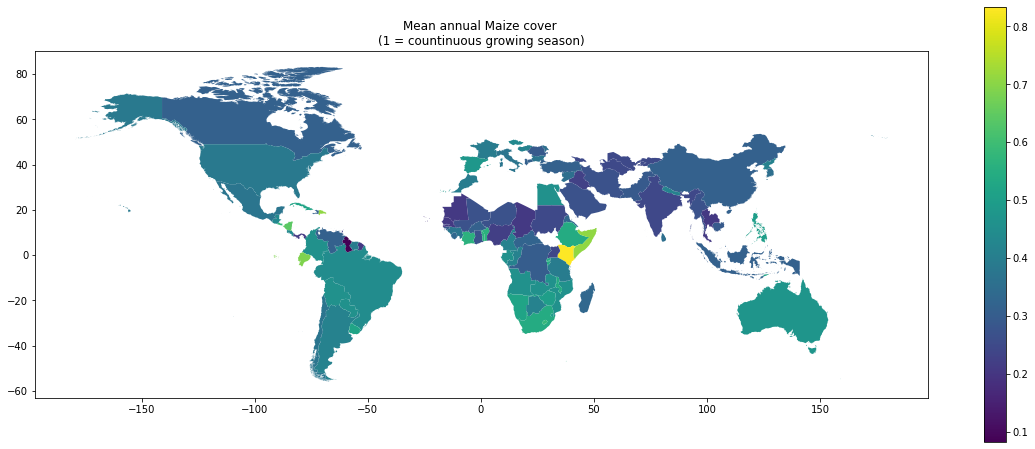

In [ ]:
f, ax = plt.subplots(figsize=(20,8))
combined_maize.plot(column='mean_annual', legend=True, ax=ax)
ax.set(title=f"Mean annual {crop_name} cover \n(1 = countinuous growing season)")
plt.show()

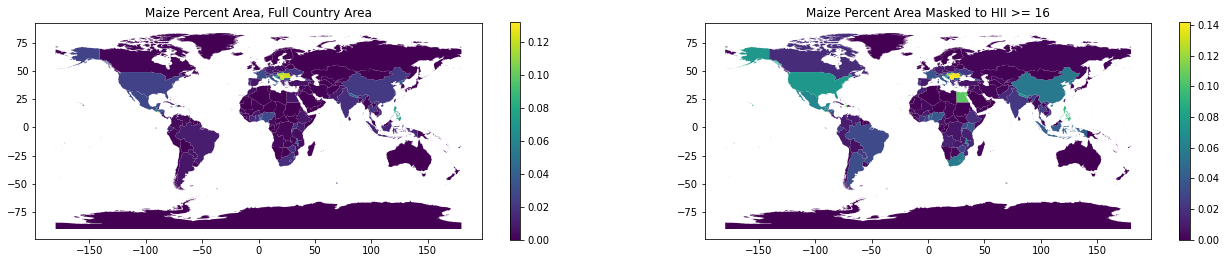

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,4))
combined_maize.plot(column='Host Percent Area - All', legend=True, ax=ax1)
combined_maize.plot(column='Host Percent Area - HII', legend=True, ax=ax2)
ax1.set(title=f"{crop_name} Percent Area, Full Country Area")
ax2.set(title=f"{crop_name} Percent Area Masked to HII >= 16")
plt.show()

[Text(0.5, 1.0, 'Maize Percent Area')]

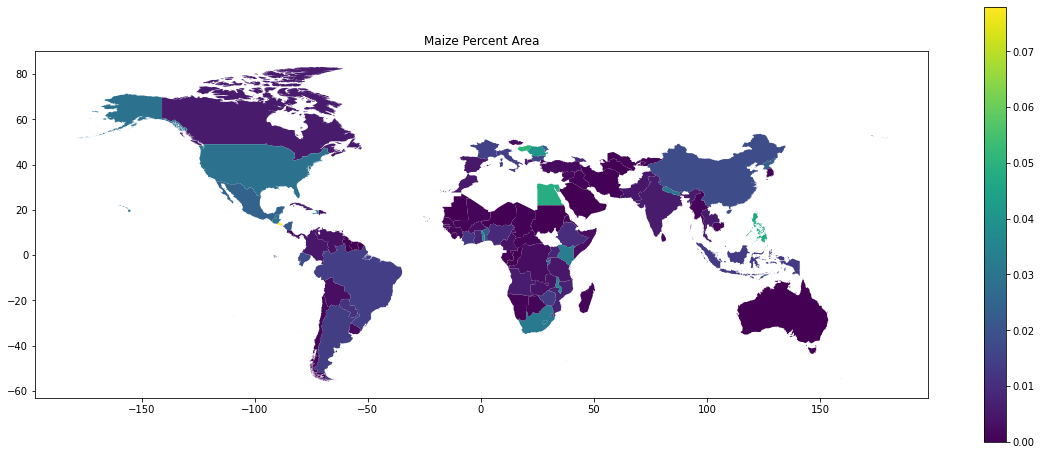

In [ ]:
combined_maize['overall_cover'] = combined_maize['Host Percent Area - All'] * combined_maize['mean_annual']
combined_maize['overall_cover_hii'] = combined_maize['Host Percent Area - HII'] * combined_maize['mean_annual']

f, ax = plt.subplots(figsize=(20,8))
combined_maize.plot(column='overall_cover_hii', legend=True, ax=ax)
ax.set(title=f"{crop_name} Percent Area")

## Looking into the missing values for Maize

In [ ]:
combined_maize[['NAME','Host Percent Area - HII','Host Percent Area - All', 'Host Percent Area - Frac', 'month_values','mean_annual','overall_cover','overall_cover_hii']].sort_values('Host Percent Area - HII',ascending=False).head(5)

,NAME,Host Percent Area - HII,Host Percent Area - All,Host Percent Area - Frac,month_values,mean_annual,overall_cover,overall_cover_hii
236,Serbia,0.141767,0.125425,0.142054,NaN,NaN,NaN,NaN
170,Romania,0.139994,0.121725,0.140997,"[0.0, 0.0, 0.25, 0.5, 1.0, 1.0, 0.5, 0.25, 0.0...",0.291667,0.035503,0.040832
54,El Salvador,0.133657,0.131793,0.136014,"[1.0, 0.25, 0.0, 0.0, 0.25, 0.5, 1.0, 0.5, 0.5...",0.583333,0.076879,0.077967
80,Hungary,0.122155,0.116235,0.123061,"[0.0, 0.0, 0.25, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5,...",0.416667,0.048431,0.050898
77,Haiti,0.108786,0.091565,0.109095,"[0.0, 0.25, 0.5, 1.0, 1.0, 0.5, 0.25, 0.25, 0....",0.312500,0.028614,0.033996


In [ ]:
## Top countries missing data, by host percent area
missing_maize = combined_maize.loc[combined_maize['mean_annual'].isna() & combined_maize['sum_area'] > 0].sort_values('Host Percent Area - All', ascending=False)

print(f"{len(missing_maize.index)} countries missing monthly values.")
missing_maize[['NAME','Host Percent Area - HII','Host Percent Area - All','Host Percent Area - Frac', 'month_values','mean_annual','overall_cover','overall_cover_hii']].head(10)

53 countries missing monthly values.


,NAME,Host Percent Area - HII,Host Percent Area - All,Host Percent Area - Frac,month_values,mean_annual,overall_cover,overall_cover_hii
236,Serbia,0.141767,0.125425,0.142054,NaN,NaN,NaN,NaN
139,Montenegro,0.097572,0.084264,0.099177,NaN,NaN,NaN,NaN
79,Croatia,0.077884,0.063397,0.079434,NaN,NaN,NaN,NaN
15,Bosnia and Herzegovina,0.042660,0.037484,0.042861,NaN,NaN,NaN,NaN
78,Honduras,0.043581,0.030891,0.044026,NaN,NaN,NaN,NaN
104,Slovakia,0.031246,0.027007,0.031205,NaN,NaN,NaN,NaN
233,San Marino,0.027946,0.024515,0.024586,NaN,NaN,NaN,NaN
206,Ukraine,0.022215,0.020491,0.022552,[],NaN,NaN,NaN
183,Slovenia,0.027022,0.020189,0.026776,NaN,NaN,NaN,NaN
56,Austria,0.023639,0.019003,0.023448,NaN,NaN,NaN,NaN


In [ ]:
# For now, using the fractional host in absence of complete calendar data

host_df.rename(columns={"Host Percent Area - Frac":"Host Percent Area"}, inplace=True)
input_dir = "inputs"

add_TWN = False
if add_TWN:
    suffix = "_wTWN"
else:
    suffix = ""

host_df[['NAME','ISO3','Host Percent Area']].to_csv(f"{input_dir}/host_hiiMask{str(threshold_val)}{suffix}.csv", sep = ',')